In [7]:
import numpy as np
import tensorflow as tf
from backend.networks import Model
import backend as be
from backend.simulation_tools import Simulator
from tasks import memory_tasks as mt
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
mem_gap_length = 100
# name = 'mem_sac_var_in_out_mem'

# weights_path = '../weights/' + name + '_' + str(mem_gap_length) + '.npz'

# weights_path = '../weights/mem_sac_fixed_100.npz'
# weights_path = '../weights/mem_sac_variable_75.npz'
weights_path = '../weights/mem_sac_fixed_noise4_50.npz'
    
#task params
input_wait = 40
stim_dur = 10
out_gap = 0
out_dur = 60

var_delay_length = 0
var_in_wait = 40
var_out_gap = 0
second_in_scale = 0.  #Only one input period or two (e.g. mem saccade no distractor vs with distractor)
task = 'memory_saccade'
name = 'mem_sac_fixed'

#model params
n_in = 2 
n_hidden = 100 
n_out = 2
#n_steps = 80 
tau = 100.0 #As double
dt = 20.0  #As double
dale_ratio = 0
rec_noise = 0.0
stim_noise = 0.1
batch_size = 128


#train params
learning_rate = .0001 
training_iters = 5000000
display_step = 200

# weights_path = '../weights/' + name + '_' + str(mem_gap_length) + '.npz'
#weights_path = None

params = mt.set_params(epochs=200, sample_size= batch_size, input_wait=input_wait, 
                    stim_dur=stim_dur, mem_gap=mem_gap_length, out_gap = out_gap, out_dur=out_dur, 
                    N_rec=n_hidden, n_out = n_out, n_in = n_in, 
                    var_delay_length=var_delay_length,
                    var_in_wait = var_in_wait, var_out_gap = var_out_gap,
                    rec_noise=rec_noise, stim_noise=stim_noise, 
                    dale_ratio=dale_ratio, tau=tau, task=task,
                    second_in_scale=second_in_scale)

generator = mt.generate_train_trials(params)

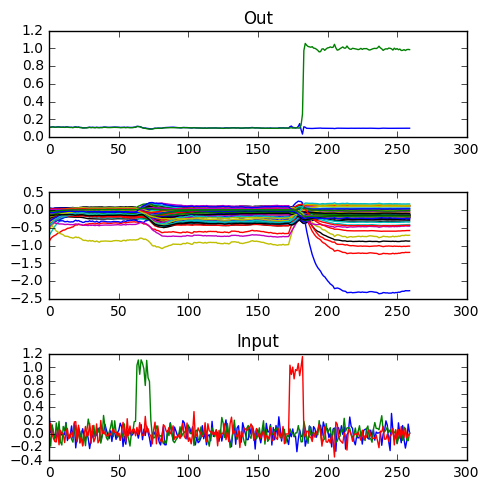

In [9]:


weights = np.load(weights_path)

W = weights['W_rec']
brec = weights['b_rec']

data = generator.next()

sim = Simulator(params, weights_path=weights_path)
output,states = sim.run_trial(data[0][0,:,:],t_connectivity=False)

plt.figure(figsize=(5,5))
plt.subplot(3,1,1)
plt.plot(output[:,0,:])
plt.title('Out')
plt.subplot(3,1,2)
plt.plot(states[:,0,:])
plt.title('State')
plt.subplot(3,1,3)
plt.plot(data[0][0,:,:])
plt.title('Input')

plt.tight_layout()
plt.show()

In [165]:
def plot_by_max(state,norm=True,thresh=.001):
    fr = np.maximum(state,thresh)
    if norm:
#         fr = ((fr-np.mean(fr,axis=0))/np.std(fr,axis=0))
        fr = ((fr-np.min(fr,axis=0))/(1e-10+np.max(fr,axis=0)-np.min(fr,axis=0)))
    idx = np.argsort(np.argmax(fr,axis=0))
    plt.pcolormesh(fr[:,idx].T)
    plt.colorbar()
    plt.xlim([0,np.shape(fr)[0]])
    
def plot_dist_to_fixed(state,fp):
    d = np.zeros(np.shape(state)[0])
    for ii in range(np.shape(state)[0]):
        d[ii] = np.sum((fp-state[ii,:])**2)
    plt.plot(d,'.')
    plt.ylim([0,np.max(d)*1.5])
    return d

def principal_angle(A,B):
    ''' A = n x p
        B = n x q'''
    
    Qa, ra = np.linalg.qr(A)
    Qb, rb = np.linalg.qr(B)
    C = np.linalg.svd(Qa.T.dot(Qb))
    angles = np.arccos(C[1])
    
    return 180*angles/np.pi

def calc_norm(A):
    return np.sqrt(np.sum(A**2,axis=0))

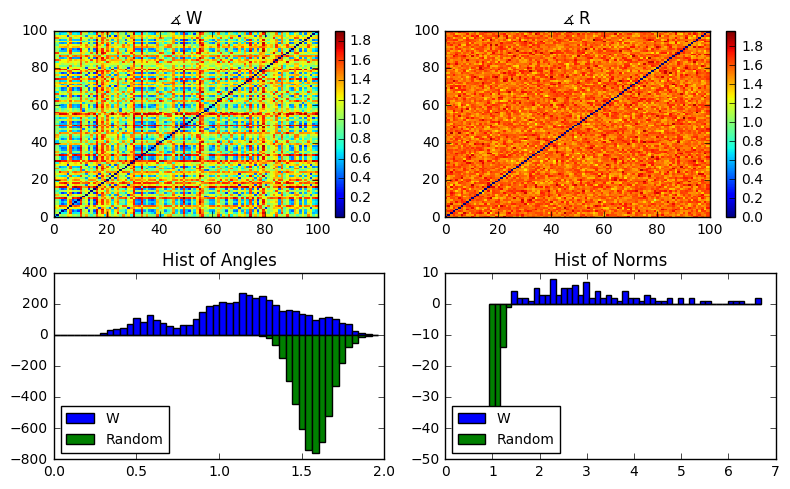

In [166]:
N = W.shape[0]

R = np.random.randn(N,N)/float(N)
R = 1.1*R/np.max(np.abs(np.linalg.eig(R)[0]))

#calculate the norm of trained rec matrix W and random gaussian matrix R

normW = calc_norm(W)
normR = calc_norm(R)

min_norm = np.min([np.min(normW),np.min(normR)])
max_norm = np.max([np.max(normW),np.max(normR)])

xx_norm = np.linspace(min_norm,max_norm,50)
histnormW, _ = np.histogram(normW,xx_norm)
histnormR, _ = np.histogram(normR,xx_norm)

#calculate hists for angles between columns

angle_W = np.arccos(np.clip((W.T.dot(W))/np.outer(normW,normW),-1.,1.))
angle_R = np.arccos(np.clip((R.T.dot(R))/np.outer(normR,normR),-1.,1.))

min_val = np.min([np.min(angle_W),np.min(angle_R)])
max_val = np.max([np.max(angle_W),np.max(angle_R)])
            
xx = np.linspace(min_val,max_val,50)
histW, bin_edgesW = np.histogram(angle_W[np.tril(np.ones_like(W),-1)>0],xx)
histR, bin_edgesR = np.histogram(angle_R[np.tril(np.ones_like(R),-1)>0],xx)

plt.figure(figsize=(8,5))
plt.subplot(2,2,1)
plt.pcolormesh(angle_W)
plt.colorbar()
plt.title('$\measuredangle$ W')

plt.subplot(2,2,2)
plt.pcolormesh(angle_R)
plt.colorbar()
plt.title('$\measuredangle$ R')

plt.subplot(2,2,3)
plt.bar(xx[:-1],histW,width=bin_edgesW[1]-bin_edgesW[0])
plt.bar(xx[:-1],-histR,width=bin_edgesR[1]-bin_edgesR[0],color='g')

plt.legend(['W','Random'],fontsize=10,loc='lower left')
plt.title('Hist of Angles')

plt.subplot(2,2,4)
plt.bar(xx_norm[:-1],histnormW,width=xx_norm[1]-xx_norm[0])
plt.bar(xx_norm[:-1],-histnormR,width=xx_norm[1]-xx_norm[0],color='g')

plt.legend(['W','Random'],fontsize=10,loc='lower left')
plt.title('Hist of Norms')


# plt.hist(R.T.dot(R)[np.tril(np.ones_like(R))>0],20,alpha=.5)

plt.tight_layout()
plt.show()

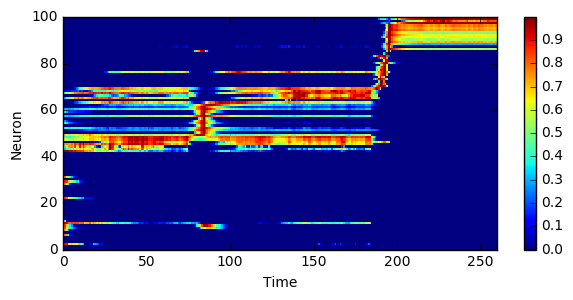

In [201]:

plt.figure(figsize=(7,3))
plot_by_max(states[:,0,:])
plt.xlabel('Time')
plt.ylabel('Neuron')

plt.show()

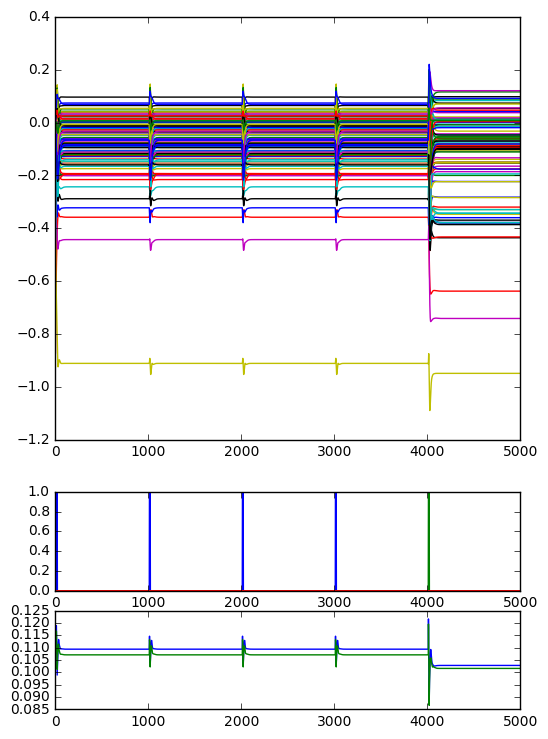

In [168]:
out0,s0,out1,s1 = mt.long_delay_test(sim)

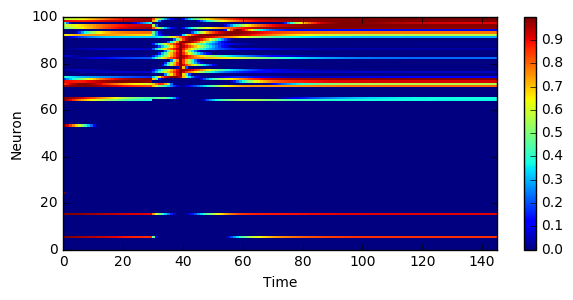

In [169]:
plt.figure(figsize=(7,3))
plot_by_max(s0[20:165,0,:])
plt.xlabel('Time')
plt.ylabel('Neuron')

plt.show()

In [170]:
fps0 = mt.fixed_point_analysis(s0[:,0,:],W,brec)
fps1 = mt.fixed_point_analysis(s1[:,0,:],W,brec)

(0, 0.1)

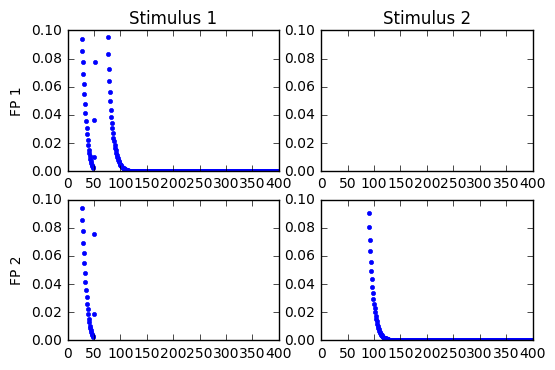

In [171]:
trial_length = data[0].shape[1]

trial_length = 400

plt.subplot(2,2,1)
d = plot_dist_to_fixed(s0[:trial_length,0,:],fps0[-1]['fp'])
plt.ylim([0,.1])
plt.title('Stimulus 1')
plt.ylabel('FP 1')
plt.subplot(2,2,2)
plt.title('Stimulus 2')
d = plot_dist_to_fixed(s0[:trial_length,0,:],fps1[-1]['fp'])
plt.ylim([0,.1])

plt.subplot(2,2,3)
d = plot_dist_to_fixed(s1[:trial_length,0,:],fps0[-1]['fp'])
plt.ylim([0,.1])
plt.ylabel('FP 2')
plt.subplot(2,2,4)
d = plot_dist_to_fixed(s1[:trial_length,0,:],fps1[-1]['fp'])
plt.ylim([0,.1])

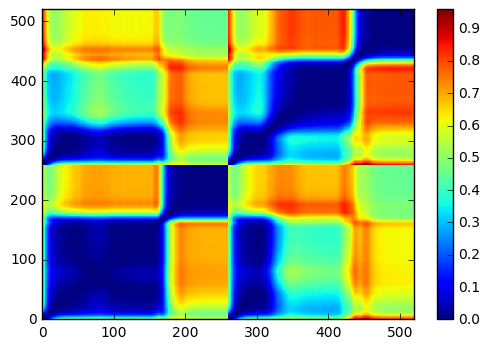

In [172]:
s = np.zeros([data[0].shape[1],data[0].shape[0],100])
for ii in range(data[0].shape[0]):
    s[:,ii,:] = sim.run_trial(data[0][ii,:,:],t_connectivity=False)[1].reshape([data[0].shape[1],100])
    
dirs = np.argmax(np.mean(data[1][:,180:200,:],axis=1),axis=1)
c_dirs = np.corrcoef(np.mean(s[:,dirs==0,:],axis=1),np.mean(s[:,dirs==1,:],axis=1))

plt.pcolormesh(1-c_dirs)
plt.colorbar()
plt.ylim([0,c_dirs.shape[0]])
plt.xlim([0,c_dirs.shape[0]])
plt.show()
# plt.pcolormesh(.5*c_dirs[200:,:200] + .5*c_dirs[:200,200:]);# - .5*c_dirs[200:,200:] - .5*c_dirs[:200,:200]), plt.colorbar();

/Users/daniel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in arccos


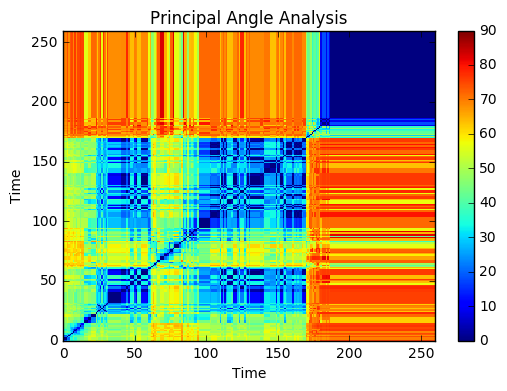

In [173]:

# masks = (np.mean(s,axis=1).T>0)
masks = s[:,2,:].T>0

# W = np.random.randn(100,100)
# dale = np.eye(100)
# dale[:,50] *= -1
# W = np.abs(W).dot(dale)

# W = 1.1*W/np.max(np.abs(np.linalg.eig(W)[0]))

max_ev = np.zeros(data[0].shape[1])

pos = []
neg = []
leading = []
for ii in range(data[0].shape[1]):
    evals,evecs = np.linalg.eig(W*masks[:,ii]-np.eye(100))
    max_ev[ii] = np.max(evals.real)
    pos.append(evecs[:,evals>0])
    neg.append(evecs[:,evals<0])
    leading.append(evecs[:,np.argsort(np.abs(evals.real))[:10]]) #.reshape([100,2]))
    

xx = np.arange(0,data[0].shape[1],1)
pa = np.zeros([len(xx),len(xx)])

basis = leading

for ii,pre in enumerate(xx):
    for jj,post in enumerate(xx):
        if basis[pre].shape[1]*basis[post].shape[1]>0:
            pas = principal_angle(basis[pre],basis[post])
            pa[ii,jj] = np.nanmean(pas)
        else:
            pa[ii,jj] = 0.
        
plt.pcolormesh(pa,vmin=0,vmax=90)
plt.colorbar()
plt.ylim([0,pa.shape[0]])
plt.xlim([0,pa.shape[1]])

plt.title('Principal Angle Analysis')
plt.xlabel('Time')
plt.ylabel('Time')
plt.show()
        

In [174]:
evals[np.argsort(np.abs(evals.real))[:10]]

array([-1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j,
       -1.+0.j, -1.+0.j, -1.+0.j])

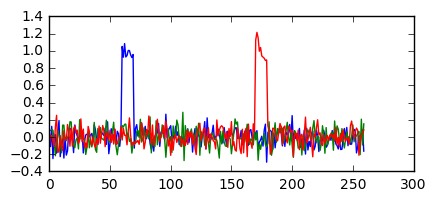

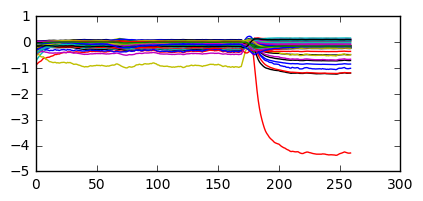

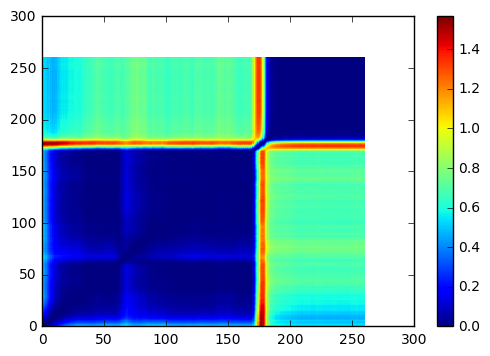

In [175]:
trial = 2

plt.figure(figsize=(4.7,2))
plt.plot(data[0][trial,:,:]);

plt.figure(figsize=(4.7,2))
plt.plot(s[:,trial,:]);

plt.figure()
plt.pcolormesh(1-np.corrcoef(s[:,trial,:]))
plt.colorbar()
# for ii in range(100):
#     plt.plot(data[0][ii,:,0],'b');
#     plt.plot(data[0][ii,:,1],'g');
#     plt.plot(data[0][ii,:,2],'r');
#     plt.plot(data[1][ii,:,:]);

/Users/daniel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in arccos


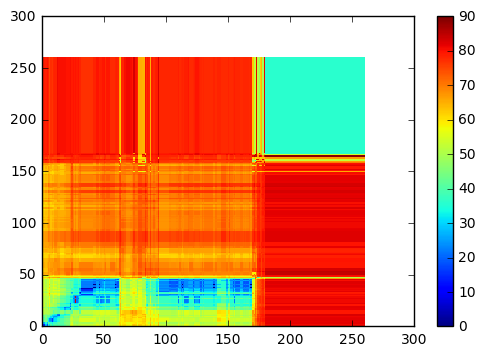

In [176]:
# masks = (np.mean(s,axis=1).T>0)
masks0 = s[:,3,:].T>0
masks1 = s[:,2,:].T>0

# W = np.random.randn(100,100)
# dale = np.eye(100)
# dale[:,50] *= -1
# W = np.abs(W).dot(dale)

# W = 1.1*W/np.max(np.abs(np.linalg.eig(W)[0]))

max_ev = np.zeros(data[0].shape[1])

# neg0 = []
# neg1 = []
leading0 = []
leading1 = []

for ii in range(data[0].shape[1]):
    evals0,evecs0 = np.linalg.eig(W*masks0[:,ii]-np.eye(100))
    evals1,evecs1 = np.linalg.eig(W*masks1[:,ii]-np.eye(100))
#     max_ev[ii] = np.max(evals.real)
#     neg0.append(evecs0[:,evals0<0])
#     neg1.append(evecs1[:,evals1<0])
    leading0.append(evecs0[:,np.argsort(np.abs(evals0.real))[:5]])
    leading1.append(evecs1[:,np.argsort(np.abs(evals1.real))[:5]])
    

xx = np.arange(0,data[0].shape[1],1)
pa = np.zeros([len(xx),len(xx)])

# basis = neg

for ii,pre in enumerate(xx):
    for jj,post in enumerate(xx):
        if leading0[pre].shape[1]*leading1[post].shape[1]>0:
            pas = principal_angle(leading0[pre],leading1[post])
            pa[ii,jj] = np.nanmean(pas)
        else:
            pa[ii,jj] = 0.
        
plt.pcolormesh(pa,vmin=0,vmax=90)
plt.colorbar()
plt.show()
        

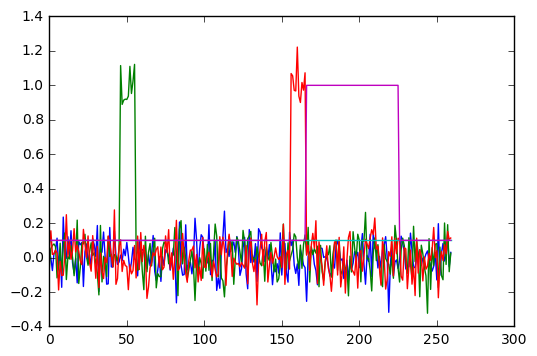

In [177]:
plt.plot(data[0][3,:,:])
plt.plot(data[1][3,:,:])

In [178]:
f = mt.state_tensor_decomposition(np.maximum(s,0),rank=6)

Using mxnet backend.


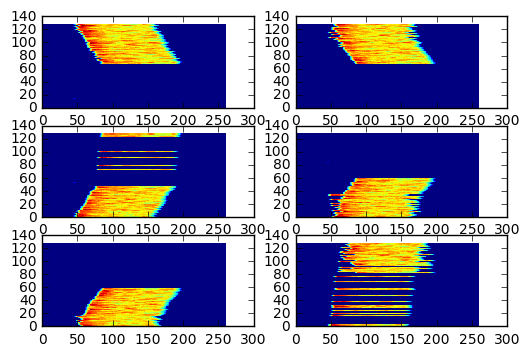

In [179]:
# plt.figure()
# plt.plot(f[0])

plt.figure()
for ii in range(6):
    plt.subplot(3,2,ii+1)
    plt.pcolormesh(np.maximum(s[:,np.argsort(f[1][:,ii]),1].T,0))
#     plt.pcolormesh(data[0][np.argsort(f[1][:,ii]),:,2])

plt.show()

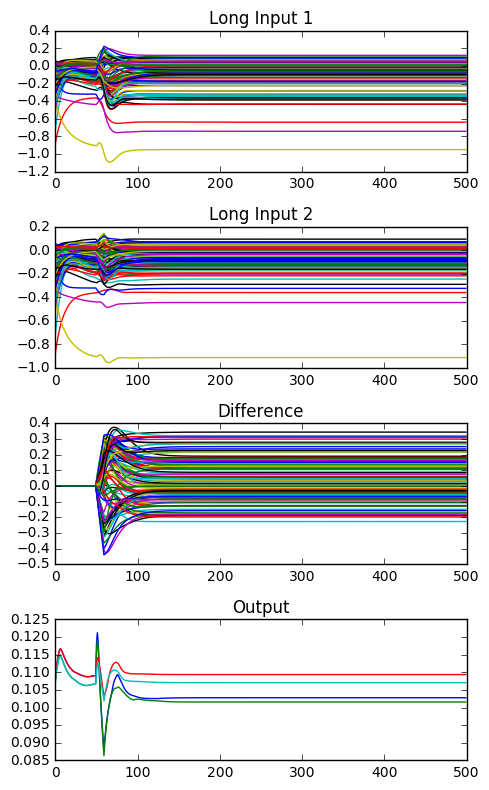

In [180]:
'''just input'''

plt.figure(figsize=(5,8))

plt.subplot(4,1,1)
plt.plot(s1[:500,0,:]);
plt.title('Long Input 1')
plt.subplot(4,1,2)
plt.plot(s0[:500,0,:]);
plt.title('Long Input 2')
plt.subplot(4,1,3)
plt.plot(s0[:500,0,:] - s1[:500,0,:]);
plt.title('Difference')
plt.subplot(4,1,4)
plt.plot(out1[:500,0,:]);
plt.plot(out0[:500,0,:]);
plt.title('Output')

plt.tight_layout()
plt.show()

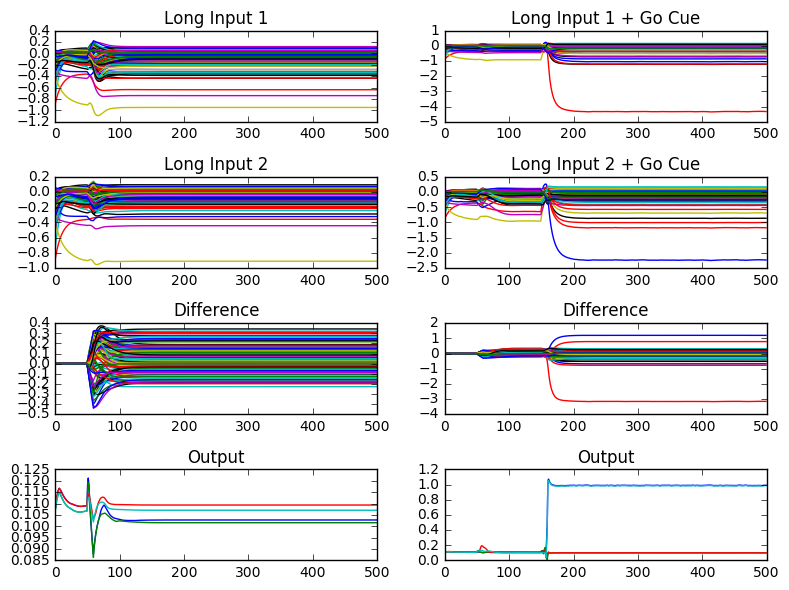

In [181]:
'''input and go cue'''

d = .01*np.random.randn(2000,3)
d[50:60,0] = 1.
d[150:160,2] = 1.
o_long0,s_long0 = sim.run_trial(d,t_connectivity=False)


d[50:60,1] = 1.
d[150:160,2] = 1.
o_long1,s_long1 = sim.run_trial(d,t_connectivity=False)

plt.figure(figsize=(8,6))

plt.subplot(4,2,1)
plt.plot(s1[:500,0,:]);
plt.title('Long Input 1')
plt.subplot(4,2,3)
plt.plot(s0[:500,0,:]);
plt.title('Long Input 2')
plt.subplot(4,2,5)
plt.plot(s0[:500,0,:] - s1[:500,0,:]);
plt.title('Difference')
plt.subplot(4,2,7)
plt.plot(out1[:500,0,:]);
plt.plot(out0[:500,0,:]);
plt.title('Output')


plt.subplot(4,2,2)
plt.plot(s_long0[:500,0,:]);
plt.title('Long Input 1 + Go Cue')
plt.subplot(4,2,4)
plt.plot(s_long1[:500,0,:]);
plt.title('Long Input 2 + Go Cue')
plt.subplot(4,2,6)
plt.plot(s_long0[:500,0,:] - s_long1[:500,0,:]);
plt.title('Difference')
plt.subplot(4,2,8)
plt.plot(o_long0[:500,0,:]);
plt.plot(o_long1[:500,0,:]);
plt.title('Output')

plt.tight_layout()
plt.show()

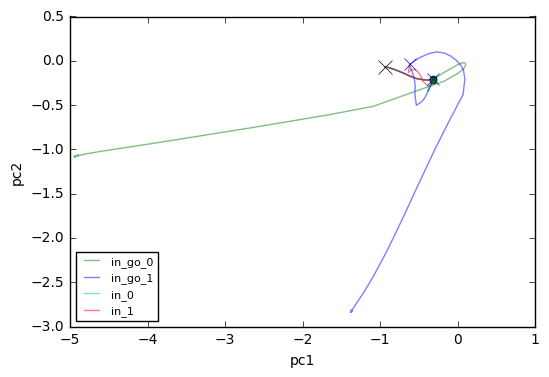

In [182]:
'''pc projection of above'''

def demean(s):
    return s-np.mean(s,axis=0)

s_pca = np.concatenate((s_long0[:500,0,:],s_long1[:500,0,:]),axis=0)
s_pca = demean(s_pca)
c_pca = np.cov(s_pca.T)
evals,evecs = np.linalg.eig(c_pca)


plt.plot(s_long0[:,0,:].dot(evecs[:,0:1]),s_long0[:,0,:].dot(evecs[:,1:2]),'g',alpha=.5)
plt.plot(s_long1[:,0,:].dot(evecs[:,0:1]),s_long1[:,0,:].dot(evecs[:,1:2]),'b',alpha=.5)
plt.plot(s0[:,0,:].dot(evecs[:,0:1]),s0[:,0,:].dot(evecs[:,1:2]),'c',alpha=.5)
plt.plot(s1[:,0,:].dot(evecs[:,0:1]),s1[:,0,:].dot(evecs[:,1:2]),'r',alpha=.5)

plt.plot(s_long1[:,0,:].dot(evecs[:,0:1])[0],s_long1[:,0,:].dot(evecs[:,1:2])[0],'kx',markersize=10)

plt.plot(s_long0[:,0,:].dot(evecs[:,0:1])[49],s_long0[:,0,:].dot(evecs[:,1:2])[49],'og',markersize=5)
plt.plot(s_long0[:,0,:].dot(evecs[:,0:1])[149],s_long0[:,0,:].dot(evecs[:,1:2])[149],'og',markersize=5)

plt.plot(s_long1[:,0,:].dot(evecs[:,0:1])[49],s_long1[:,0,:].dot(evecs[:,1:2])[49],'xb',markersize=8)
plt.plot(s_long1[:,0,:].dot(evecs[:,0:1])[149],s_long1[:,0,:].dot(evecs[:,1:2])[149],'xb',markersize=8)

plt.xlabel('pc1')
plt.ylabel('pc2')

plt.legend(['in_go_0','in_go_1','in_0','in_1'],loc='lower left',fontsize=8)
plt.show()


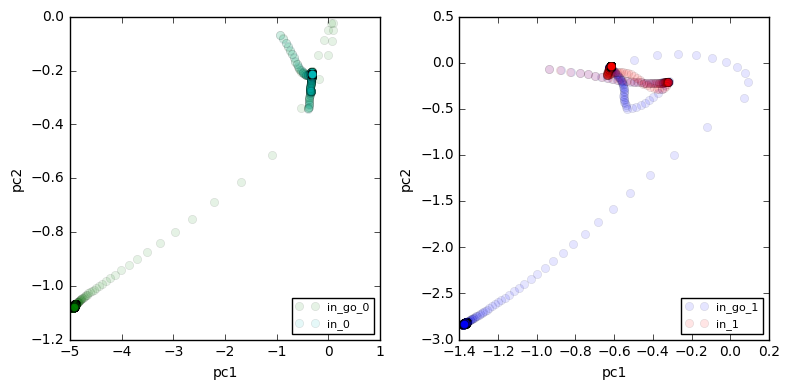

In [183]:
'''pc projection as above but with points for velocity inference'''

def demean(s):
    return s-np.mean(s,axis=0)

s_pca = np.concatenate((s_long0[:500,0,:],s_long1[:500,0,:]),axis=0)
s_pca = demean(s_pca)
c_pca = np.cov(s_pca.T)
evals,evecs = np.linalg.eig(c_pca)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(s_long0[:,0,:].dot(evecs[:,0:1]),s_long0[:,0,:].dot(evecs[:,1:2]),'og',alpha=.1)
plt.plot(s0[:,0,:].dot(evecs[:,0:1]),s0[:,0,:].dot(evecs[:,1:2]),'oc',alpha=.1)

plt.xlabel('pc1')
plt.ylabel('pc2')
plt.legend(['in_go_0','in_0'],loc='lower right',fontsize=8)

plt.subplot(1,2,2)
plt.plot(s_long1[:,0,:].dot(evecs[:,0:1]),s_long1[:,0,:].dot(evecs[:,1:2]),'ob',alpha=.1)
plt.plot(s1[:,0,:].dot(evecs[:,0:1]),s1[:,0,:].dot(evecs[:,1:2]),'or',alpha=.1)

plt.xlabel('pc1')
plt.ylabel('pc2')
plt.legend(['in_go_1','in_1'],loc='lower right',fontsize=8)

plt.tight_layout()
plt.show()

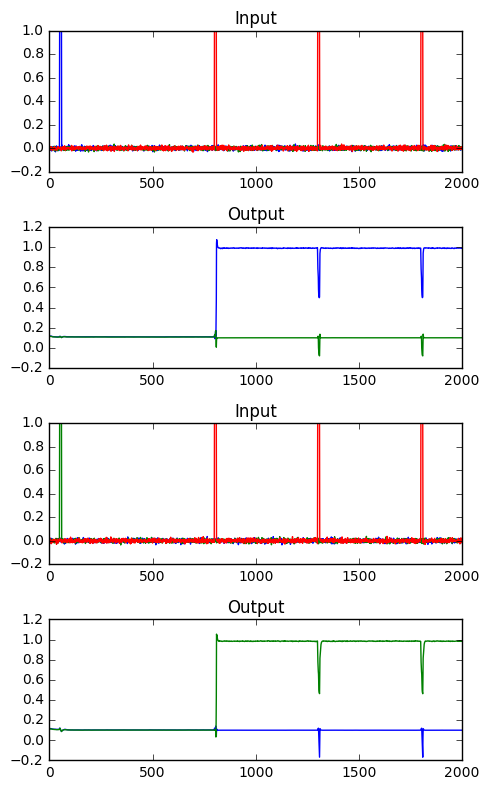

In [10]:
d = .01*np.random.randn(2000,3)
d[50:60,0] = 1.
# d[100:110,1] = 2.
# d[200:210,0] = 2.
# d[300:310,1] = 2.
d[800:810,2] = 1.
d[1300:1310,2] = 1.
d[1800:1810,2] = 1.

o_long,s_long = sim.run_trial(d,t_connectivity=False)

plt.figure(figsize=(5,8))

plt.subplot(4,1,1)
plt.plot(d)
plt.title('Input')

plt.subplot(4,1,2)
plt.plot(o_long[:,0,:]);
plt.title('Output')

d = .01*np.random.randn(2000,3)
d[50:60,1] = 1.
# d[100:110,1] = 2.
# d[200:210,0] = 2.
# d[300:310,1] = 2.
d[800:810,2] = 1.
d[1300:1310,2] = 1.
d[1800:1810,2] = 1.

o_long,s_long = sim.run_trial(d,t_connectivity=False)

plt.subplot(4,1,3)
plt.plot(d)
plt.title('Input')

plt.subplot(4,1,4)
plt.plot(o_long[:,0,:]);
plt.title('Output')

plt.tight_layout()
plt.show()

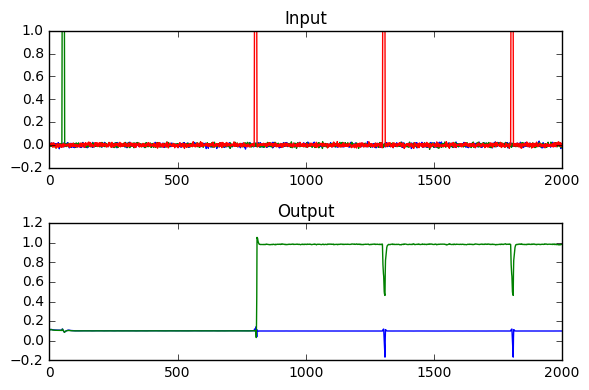

In [185]:
d = .01*np.random.randn(2000,3)
d[50:60,1] = 1.
# d[100:110,1] = 2.
# d[200:210,0] = 2.
# d[300:310,1] = 2.
d[800:810,2] = 1.
d[1300:1310,2] = 1.
d[1800:1810,2] = 1.

o_long,s_long = sim.run_trial(d,t_connectivity=False)

plt.subplot(2,1,1)
plt.plot(d)
plt.title('Input')

plt.subplot(2,1,2)
plt.plot(o_long[:,0,:]);
plt.title('Output')

plt.tight_layout()
plt.show()

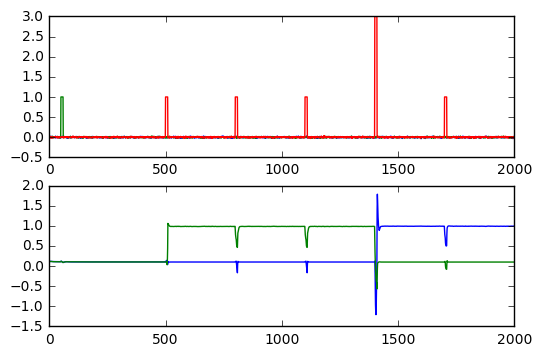

In [186]:
d = .01*np.random.randn(2000,3)
d[50:60,1] = 1.

d[500:510,2] = 1.
d[800:810,2] = 1.
d[1100:1110,2] = 1.
d[1400:1410,2] = 3.
d[1700:1710,2] = 1.


o_long,s_long = sim.run_trial(d,t_connectivity=False)

plt.subplot(2,1,1)
plt.plot(d)

plt.subplot(2,1,2)
plt.plot(o_long[:,0,:]);

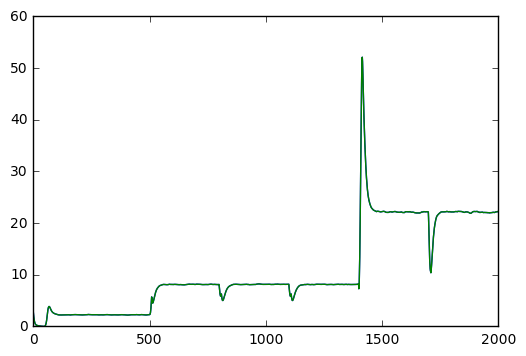

In [187]:
dist2fp0 = plot_dist_to_fixed(s_long,fps0[0]['fp'])
dist2fp1 = plot_dist_to_fixed(s_long,fps1[0]['fp'])

plt.cla()

plt.plot(dist2fp0)
plt.plot(dist2fp1)

In [188]:
n_steps = 2500
n_hidden = W.shape[0]
x = np.zeros([n_hidden,n_steps])

alpha = .1

fps_diff = fps0[-1]['fp'] - fps1[-1]['fp']

pulse10 = fps_diff/alpha
pulse01 = -fps_diff/alpha

mu = .0*np.random.randn(n_hidden,n_steps)

mu[:,500] = pulse10
mu[:,1000] = pulse01
mu[:,1500] = pulse10*.8



for ii in range(n_steps):
    x[:,ii] = (1-alpha)*x[:,ii-1] + alpha * (W.dot(np.maximum(x[:,ii-1],0))+brec + mu[:,ii])

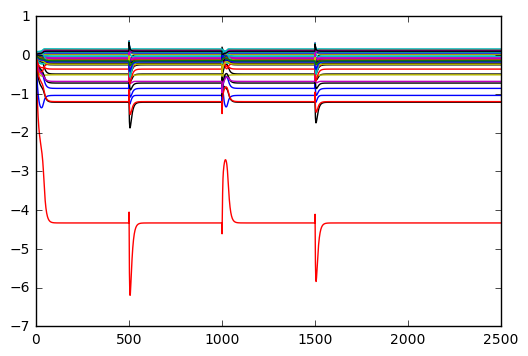

In [189]:
plt.plot(x.T);

(0, 0.3)

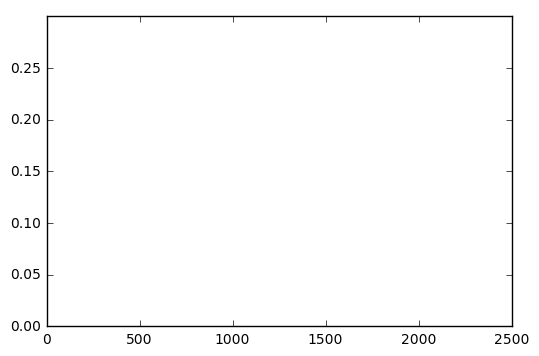

In [190]:
plot_dist_to_fixed(x.T,fps1[-1]['fp']);
plt.ylim([0,.3])
# plot_dist_to_fixed(x.T,s[0,0,:]);

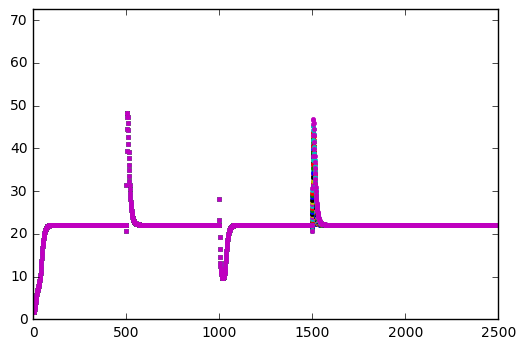

In [191]:
n_steps = 2500
n_hidden = W.shape[0]
x = np.zeros([n_hidden,n_steps])

fps_diff = fps0[-1]['fp'] - fps1[-1]['fp']

pulse10 = fps_diff/alpha
pulse01 = -fps_diff/alpha

mu = .0*np.random.randn(n_hidden,n_steps)

mu[:,500] = pulse10
mu[:,1000] = pulse01

for jj in np.arange(.05,1,.05):
    
    x = np.zeros([n_hidden,n_steps])
    
    mu[:,1500] = pulse10*jj

    alpha = .1

    for ii in range(n_steps):
        x[:,ii] = (1-alpha)*x[:,ii-1] + alpha * (W.dot(np.maximum(x[:,ii-1],0))+brec + mu[:,ii])
        
    plot_dist_to_fixed(x.T,fps1[0]['fp']);
    
# plt.ylim([0,.3])

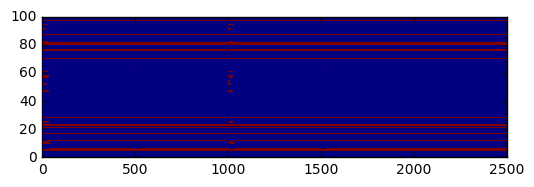

In [192]:
plt.subplot(2,1,1)
plt.pcolormesh(x>0);


In [193]:
masks = s[:,5,:].T>0

x_hat = np.zeros(masks.shape)

# plt.pcolormesh(masks)

for ii in range(masks.shape[1]):
    Weff = W*masks[:,ii]
    
    x_hat[:,ii] = np.linalg.inv(np.eye(100)-Weff).dot(brec)

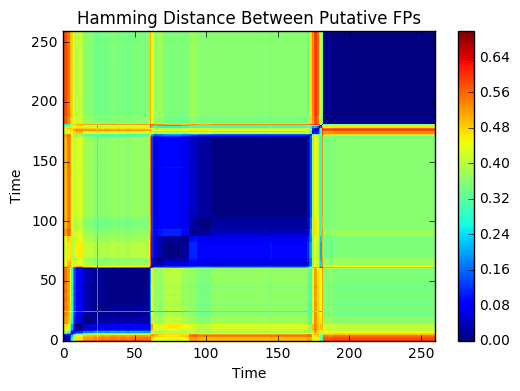

In [194]:
from scipy.spatial.distance import pdist, squareform

plt.pcolormesh(squareform(pdist(np.sign(x_hat[:,:]).T,metric='hamming'))) #,vmax=.3)
plt.colorbar()
plt.ylim([0,x_hat.shape[1]])
plt.xlim([0,x_hat.shape[1]])

plt.title('Hamming Distance Between Putative FPs')
plt.ylabel('Time')
plt.xlabel('Time')

plt.show()

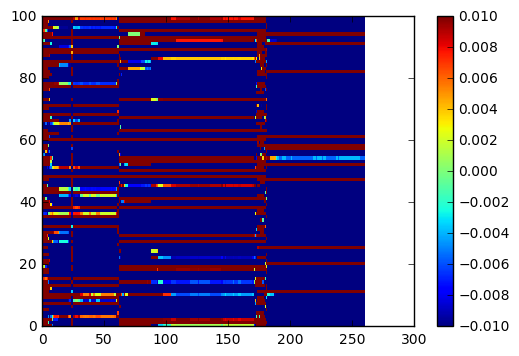

In [195]:
plt.pcolormesh(x_hat,vmax=.01,vmin=-.01)
plt.colorbar()
plt.show()

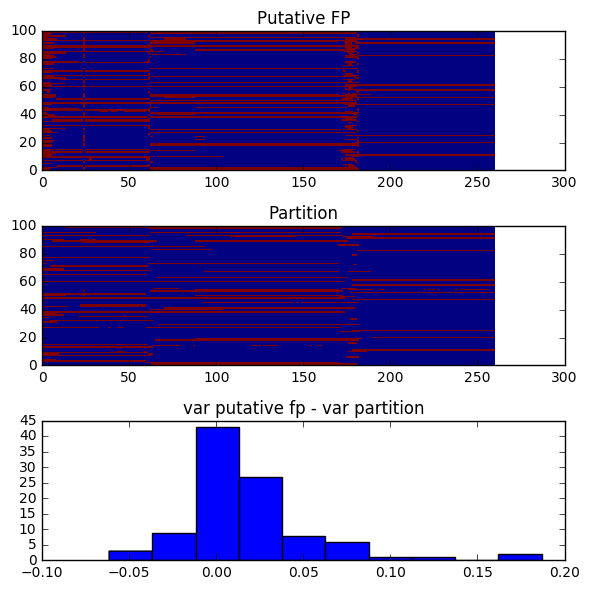

In [196]:
# print np.var(x_hat>0,axis=1)- np.var(masks,axis=1)
# print np.mean(np.var(masks,axis=1))

plt.figure(figsize=(6,6))

plt.subplot(3,1,1)
plt.pcolormesh(x_hat>0)
plt.title('Putative FP')

plt.subplot(3,1,2)
plt.pcolormesh(masks)
plt.title('Partition')

plt.subplot(3,1,3)
plt.hist(np.var(x_hat>0,axis=1)- np.var(masks,axis=1))
plt.title('var putative fp - var partition')

plt.tight_layout()
plt.show()

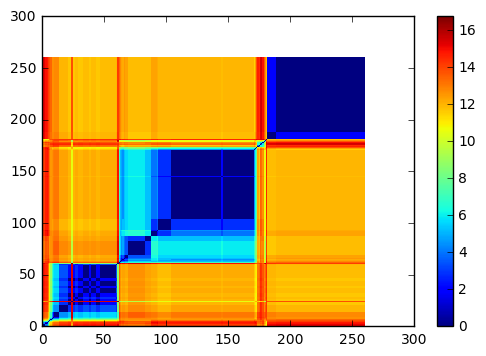

In [197]:
from scipy.spatial.distance import pdist, squareform

plt.pcolormesh(squareform(pdist(np.sign(x_hat[:,:]).T))) #,vmax=.3)
plt.colorbar()
plt.show()


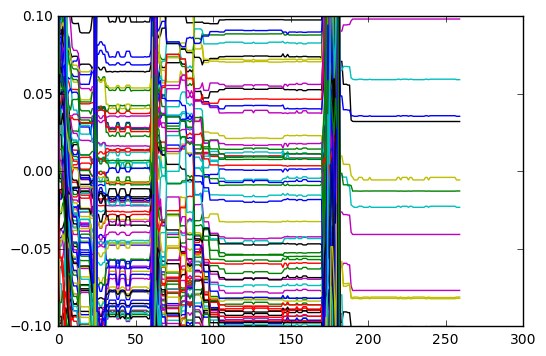

In [198]:
plt.plot(x_hat.T)
plt.ylim([-.1,.1])
plt.show()

In [199]:
x_hat.shape

(100, 260)

/Users/daniel/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


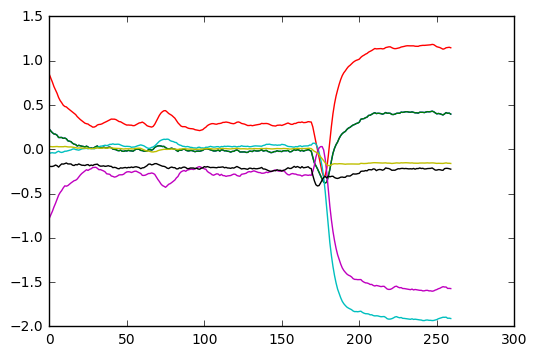

In [200]:
Weff = W*fps1[-1]['partition']

evals,evecs = np.linalg.eig(Weff-np.eye(100))

lead_evals = np.argsort(np.abs(evals.real))

plt.plot(s[:,2,:].dot(evecs[:,lead_evals[0:7]]));

0